In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import numpy as np
import pickle
import pandas as pd
import tqdm.notebook.tqdm as progress_bar
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cargar datos

## Embeddings

In [2]:
with open('index_item_and_embedding_matrix_dict.pickle', 'rb') as f:
    index_emb_dict = pickle.load(f)

index_item_matrix = torch.LongTensor(index_emb_dict['index_item_matrix'])
embedding_matrix = torch.Tensor(index_emb_dict['embedding_matrix'])
unique_tokens_d = index_emb_dict['unique_tokens_d']

In [3]:
index_item_matrix.shape

torch.Size([10681, 39])

In [4]:
n_items = index_item_matrix.shape[0]
embedding_matrix.shape

torch.Size([10701, 300])

In [5]:
n_items

10681

## Ratings

In [6]:
PID = "spike-sandbox"

query = """
SELECT *
FROM EVIC.ratings
"""
ratings = pd.read_gbq(query, project_id=PID, use_bqstorage_api=True)

In [7]:
ratings.head()

,user_id,movie_id,rating
0,6,4369,2.0
1,8,4992,2.0
2,8,5609,2.0
3,8,5833,2.0
4,12,3593,2.0


In [8]:
n_users = ratings.user_id.nunique()
print(n_users)

69878


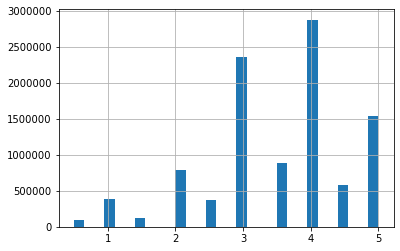

In [9]:
ratings.rating.hist(bins=30)

## Generar índices de peliculas y usuarios

In [10]:
ratings['movie_id'] = ratings['movie_id'].astype("category")
ratings['movie_idx'] = ratings['movie_id'].cat.codes

movie_dict = pd.concat([ratings['movie_id'], ratings['movie_idx']], axis=1)
movie_dict.rename(columns={0: 'id'}, inplace=True)

movie_dict = movie_dict.drop_duplicates().sort_values(by='movie_idx')
movie_dict.set_index('movie_idx', inplace=True)

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['user_idx'] = ratings['user_id'].cat.codes

user_dict = pd.concat([ratings['user_id'], ratings['user_idx']], axis=1)
user_dict.rename(columns={0: 'id'}, inplace=True)

user_dict = user_dict.drop_duplicates().sort_values(by='user_idx')
user_dict.set_index('user_idx', inplace=True)

In [11]:
ratings.head()

,user_id,movie_id,rating,movie_idx,user_idx
0,6,4369,2.0,4276,5
1,8,4992,2.0,4898,7
2,8,5609,2.0,5511,7
3,8,5833,2.0,5735,7
4,12,3593,2.0,3504,11


## Generar preference

In [12]:
ratings_matrix = pd.pivot_table(ratings, index='movie_idx', columns='user_idx', values='rating')

In [13]:
sparcity = round(100 * ratings_matrix.isna().sum().sum() / ratings_matrix.size, 2)
print(f'sparcity = {sparcity}%')

sparcity = 98.66%


In [14]:
ratings_matrix = ratings_matrix.fillna(0)

In [15]:
rating_thresh = 3.5

ratings_full = ratings_matrix.unstack().to_frame('rating').reset_index()
ratings_full['preference'] = ratings_full.eval(f'(rating >= {rating_thresh})').astype('int')

#extraer tensores 
movie_idx = torch.LongTensor(ratings_full['movie_idx'].values)
user_idx = torch.LongTensor(ratings_full['user_idx'].values)
cofidence = torch.Tensor(ratings_full['rating'].values)
preference = torch.Tensor(ratings_full['preference'].values)

ratings_full.head()

,user_idx,movie_idx,rating,preference
0,0,0,0.0,0
1,0,1,0.0,0
2,0,2,0.0,0
3,0,3,0.0,0
4,0,4,0.0,0


In [16]:
nsamples = 1000
#ratings_full[['rating', 'preference']].sample(nsamples).hist(bins=20, figsize=(10, 5));

# Modelo

## Definir modelo

In [17]:
def trunc_normal_(x, mean=0, std=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

def embedding(ni:int,nf:int):
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_users_factors, 
                 n_users, n_items, index_item_matrix, embedding_matrix, y_range=None):
        super().__init__()
        self.y_range = y_range
        #generar embedings de usuarios y bias de usuarios e items
        (self.u_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_users_factors), (n_users, 1), (n_items, 1)]]
        
        self.index_item_matrix = index_item_matrix # N_glosas x Largo_maximo_glosas 
        self.embedding_matrix = embedding_matrix # (N_palabras + 1) x N_latentes
        
        self.largo_max_glosas = index_item_matrix.shape[1]
        self.n_latent = embedding_matrix.shape[1]
        #https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d
        kernel_size = self.largo_max_glosas * self.n_latent - n_users_factors + 1
        self.conv = torch.nn.Conv1d(1, 1, kernel_size=kernel_size)

    def forward(self, users, items):
        idx_items = self.index_item_matrix[items] #indices de palabras en las glosas Nitems x Largo_max
        i_weights_full = self.embedding_matrix[idx_items] #latentes de glosas
        i_weight = self.conv(i_weights_full.reshape((len(items), 1, -1))).squeeze()
        dot = self.u_weight(users) * i_weight
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

## Inicializar

In [18]:
n_users_factors = 30
model = EmbeddingDotBias(n_users_factors, n_users, n_items, 
                         index_item_matrix, embedding_matrix, 
                         y_range=[-.01, 1.01])

In [19]:
model

EmbeddingDotBias(
  (u_weight): Embedding(69878, 30)
  (u_bias): Embedding(69878, 1)
  (i_bias): Embedding(10681, 1)
  (conv): Conv1d(1, 1, kernel_size=(11671,), stride=(1,))
)

In [20]:
[(x[0], x[1].shape) for x in model.named_parameters()]

[('u_weight.weight', torch.Size([69878, 30])),
 ('u_bias.weight', torch.Size([69878, 1])),
 ('i_bias.weight', torch.Size([10681, 1])),
 ('conv.weight', torch.Size([1, 1, 11671])),
 ('conv.bias', torch.Size([1]))]

## Entrenar

In [51]:
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-4)#, weight_decay=1e-5)#Con regularización
bs = 10
alpha = torch.Tensor(10)

idx_batchs = np.arange(0, len(ratings_full), bs)
np.random.shuffle(idx_batchs)

In [53]:
losses = []

for i in progress_bar(idx_batchs[:10000]):
    
    
    users = user_idx[idxs]
    items = movie_idx[idxs]
    p = preference[idxs]
    c = cofidence[idxs]

    prediction = model(users, items)
    loss = ((1+alpha*c)*(prediction - p)**2).mean()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses += [loss]

/Users/camiloiturracisternas/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


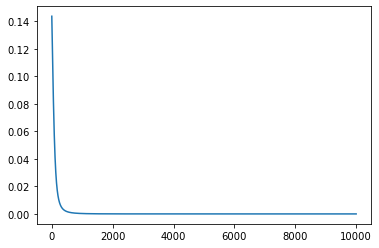

In [54]:
plt.plot(np.array([x.detach().numpy() for x in losses]))